# ELM DPU example: MNIST Classifier
-- modified from offical DPU-PYNQ projects

## 1. Prepare the overlay

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [2]:
overlay.load_model("ELM_CNN_kv260.xmodel")

Let's import some libraries as well. The `mnist` package
requires some additional headers for URL requests.

In [2]:
from time import time
import numpy as np
import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## 2. Load test data

The `mnist` package enables the following data for users:

* `test_images()`: returns test images stored as a numpy array. 
Each image is a grayscale 28x28 pixels, representing a digit between 0 and 9.
* `test_labels()`: returns a list of the true labels stored as numpy array.


There are 2 pre-processing steps we need to do to the test images 
before we can use it:

1. The raw numpy array delivered by `mnist` has a data type of 
uint8 (data ranges from 0 to 255); we need to normalize the elements to 
floating-point numbers ranging from 0 to 1.
2. The VART API will expect each input sample to have 3 dimensions; 
so we need to expand the original numpy array.

In [4]:
raw_train = mnist.train_images()
normalized_data = np.asarray(raw_train/255, dtype=np.float32)
train_data = np.expand_dims(normalized_data, axis=3)
train_label = mnist.train_labels()

print("Total number of train images: {}".format(train_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(train_data.shape[1],
                                                  train_data.shape[2]))

Total number of train images: 60000
  Dimension of each picture: 28x28


In [5]:
raw_data = mnist.test_images()
normalized_data = np.asarray(raw_data/255, dtype=np.float32)
test_data = np.expand_dims(normalized_data, axis=3)
test_label = mnist.test_labels()

print("Total number of test images: {}".format(test_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(test_data.shape[1],
                                                  test_data.shape[2]))

Total number of test images: 10000
  Dimension of each picture: 28x28


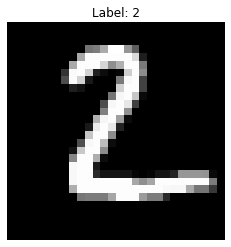

In [6]:
plt.imshow(test_data[1,:,:,0], 'gray')
plt.title('Label: {}'.format(test_label[1]))
plt.axis('off')
plt.show()

## 3. Use VART
Now we should be able to use VART API to do the task.

In [7]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0]) # here we have outputsize = 576, for it is mid-output

We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [8]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

We will also define a few functions to calculate softmax.

In [11]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

In [9]:
total = train_data.shape[0]
mid_predictions = np.empty((total,outputSize))
print("getting train output from DPU model,shape(60000,576)")
# print(mid_predictions.shape)
assert mid_predictions.shape ==(60000,576)
for i in range(total):
    image[0,...] = train_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
# Debug utils
#     print(type(temp[0][0]))
#     print(mid_predictions[[i]].shape)
#     print(temp[0][0].shape)
    mid_predictions[[i]]=temp
assert mid_predictions.shape ==(60000,576)
np.save("train_elm.npy",mid_predictions)

total = test_data.shape[0]
mid_predictions = np.empty((total,outputSize))
print("getting test output from DPU model,shape(10000,576)")
# print(mid_predictions.shape)
assert mid_predictions.shape ==(10000,576)
for i in range(total):
    image[0,...] = train_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
#     print(type(temp[0][0]))
#     print(mid_predictions[[i]].shape)
#     print(temp[0][0].shape)
    mid_predictions[[i]]=temp
assert mid_predictions.shape ==(10000,576)
np.save("test_elm.npy",mid_predictions)


getting train output from DPU model,shape(60000,576)
getting test output from DPU model,shape(10000,576)


## 5.Basic ELM
The following ELMRegressor is a simple ELM structure.

In [27]:
import numpy as np

class ELMRegressor():
    def __init__(self, n_hidden_units,output_shape):
        self.n_hidden_units = n_hidden_units
        self.output_shape = output_shape

    def fit(self, X, labels):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        self.random_weights = np.random.randn(X.shape[1], self.n_hidden_units)
        G = np.tanh(X.dot(self.random_weights))
        self.w_elm = np.linalg.pinv(G).dot(labels)

    def predict(self, X):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        G = np.tanh(X.dot(self.random_weights))
        return G.dot(self.w_elm)

# elm = ELMRegressor(n_hidden_units=100)
# elm.fit(train_x, train_y)

# prediction = elm.predict(test_x)

# elm = ELMRegressor(n_hidden_units=500,output_shape=10)
# elm.fit(train_x, train_y)
# prediction = elm.predict(test_x)
# prediction.shape


## 6.IELM 
[Incremental-Extreme-Learning-Machine-IELM](https://github.com/ankitpatel21/Incremental-Extreme-Learning-Machine-IELM)

In [31]:
import numpy as np

class I_ELM():
    """ Constructor to initialize node"""
    def __init__(self, no_input_nodes, max_no_hidden_nodes, no_output_nodes,
        activation_function='sigmoid', loss_function='mean_squared_error'):

        #self.name = name
        self.no_input_nodes = no_input_nodes
        self.no_hidden_nodes = 1
        self.no_output_nodes = no_output_nodes

        # initialize weights between  hidden layer and Output Layer
        self.beta = np.random.uniform(-1.,1.,size=(self.no_hidden_nodes, self.no_output_nodes))
        # initialize weights between Input Layer and hidden layer
        self.alpha = np.random.uniform(-1.,1.,size=(self.no_input_nodes, self.no_hidden_nodes))
        #Initialize Biases
        self.bias = np.zeros(shape=(self.no_hidden_nodes,))
        # set an activation function
        self.activation_function = activation_function
        # set a loss function
        self.loss_function = loss_function
    
    def mean_squared_error(self,Y_True, Y_Pred):
        return 0.5 * np.mean((Y_True - Y_Pred)**2)

    def mean_absolute_error(self, Y_True, Y_Pred):
        return np.mean(np.abs(Y_True - Y_Pred))
    
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def predict(self, X):
        return list(self(X))
    
    def __call__(self, X):
        h = self.sigmoid(X.dot(self.alpha) + self.bias)
        return h.dot(self.beta)

    def evaluate(self, X, Y_true, metrics=['loss']):
        Y_pred = self.predict(X)
        Y_true = Y_true
        Y_pred_argmax = np.argmax(Y_pred, axis=-1)
        Y_true_argmax = np.argmax(Y_true, axis=-1)
        ret = []
        for m in metrics:
            if m == 'loss':
                loss = self.mean_squared_error(Y_true, Y_pred)
                ret.append(loss)
            elif m == 'accuracy':
                acc = np.sum(Y_pred_argmax == Y_true_argmax) / len(Y_true)
                ret.append(acc)
            else:
                raise ValueError('an unknown evaluation indicator \'%s\'.' % m)
        if len(ret) == 1:
            ret = ret[0]
        elif len(ret) == 0:
            ret = None
        return ret

    def fit(self, X, Y_true,Lmax,error):
        self.beta = np.random.uniform(-1.,1.,size=(1, self.no_output_nodes))
        self.alpha = np.random.uniform(-1.,1.,size=(self.no_input_nodes, 1))
#         print(self.beta.shape,self.alpha.shape)
        H = self.sigmoid(X.dot(self.alpha))
        # compute a pseudoinverse of H
        H_pinv = np.linalg.pinv(H)
        # update beta
        self.beta = H_pinv.dot(Y_true)

        
        for i in range(2,Lmax):
            beta_random = np.random.uniform(-1.,1.,size=(1, self.no_output_nodes))
            alpha_random = np.random.uniform(-1.,1.,size=(self.no_input_nodes, 1))
            self.alpha=np.hstack([self.alpha,alpha_random])
#             print(self.beta.shape,beta_random.shape)
            self.beta = np.vstack([self.beta,beta_random])
            H = self.sigmoid(X.dot(self.alpha))
            # compute a pseudoinverse of H
            H_pinv = np.linalg.pinv(H)
            # update beta
            self.beta = H_pinv.dot(Y_true)

In [3]:
# prepare train data
train_x = np.load("train_elm.npy")
train_y = mnist.train_labels().reshape(train_x.shape[0],1)
test_x = np.load("test_elm.npy")
test_y = mnist.test_labels().reshape(test_x.shape[0],1)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(60000, 576)
(60000, 1)
(10000, 576)
(10000, 1)


In [22]:
def to_categorical(labels,num_classes): #label (num，1)
    if np.max(labels)>num_classes:
        print("num label bigger than num classes")
    array = labels.squeeze(axis=1).tolist()
    one_label = np.eye(num_classes)[array]
    return one_label
Y_Train = to_categorical(train_y, 10).astype(np.float32)
print(Y_Train.shape)
# check if label is unchanged
for i in range(train_y.shape[0]):
#     print(train_y[i,:][0])
#     print(Y_Train[i,:][train_y[i,:][0]])
    assert Y_Train[i,:][train_y[i,:][0]]==1.0
print("labels all checked and there is no wrong label")

(60000, 10)


In [43]:
num_classes = 10
Lmax = 100 # this param should not be so big, fot it can be quite long to train
error = 0.1
loss_function = "mean_squared_error"  #It can be mean_absolute_error also

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    sigma[sigma==0]=1
    return (data - mu) / sigma

# Normalization
# X_Train = normalization(train_x.astype(np.float32))# / 255.
# X_Test = normalization(test_x.astype(np.float32))# / 255.

#Standardization
X_Train = standardization(train_x.astype(np.float32))
X_Test = standardization(test_x.astype(np.float32))

#divided by max value
# X_Train=train_x.astype(np.float32)/np.max(train_x)
# X_Test=test_x.astype(np.float32)/np.max(test_x)

# make one hot label
Y_Train = to_categorical(train_y, num_classes).astype(np.float32)
Y_Test = to_categorical(test_y, num_classes).astype(np.float32)

In [44]:
activation_function = "sigmoid"
model = I_ELM(
        no_input_nodes=train_x.shape[1],
        max_no_hidden_nodes=Lmax,
        no_output_nodes=num_classes,
        loss_function=loss_function,
        activation_function=activation_function,  
    )
import time
i = time.time()
model.fit(X_Train, Y_Train,Lmax,error)
final = time.time()
training_loss, training_acc = model.evaluate(X_Train, Y_Train, metrics=['loss', 'accuracy'])
print('Training Loss in mean square error: %f' % training_loss) # loss value
print('Training Accuracy: %f' % training_acc)# accuracy
print('Total Time require for Training %f Seconds'% (final-i))

KeyboardInterrupt: 

In [ ]:
i = time.time()
test_loss, test_acc = model.evaluate(X_Test, Y_Test, metrics=['loss', 'accuracy'])
final = time.time()
print('Test Loss in mean square error: %f' % test_loss) # loss value
print('Test Accuracy: %f' % test_acc)# accuracy
print('Total Time require for Test %f Seconds'% (final-i))

## 7.Result Analysis
The reason I did not get expected accuracy result is that we have INT8 network at previous steps, and ELM is FP32.
the following code is a sample of train_x of mid-output which was generated by DPU inferenced xmodel. Compared With original data, it is has more repeated values, which gives no valuable information. So there is no way that ELM can deal with it without some data processing.
I have no idea at this moment, hope I can figure it out later.

In [45]:
train_x[1]

array([3.96875, 2.34375, 3.46875, 3.96875, 0.     , 3.96875, 0.     ,
       2.40625, 1.53125, 3.96875, 3.96875, 0.     , 0.     , 3.375  ,
       0.     , 0.     , 3.96875, 3.96875, 3.40625, 0.     , 3.96875,
       3.96875, 0.     , 0.     , 3.96875, 0.     , 0.     , 0.     ,
       3.96875, 0.     , 0.     , 3.96875, 0.     , 0.     , 3.96875,
       0.53125, 0.     , 3.96875, 0.     , 0.1875 , 3.96875, 0.     ,
       0.     , 0.     , 3.96875, 0.0625 , 0.     , 0.     , 0.     ,
       3.96875, 3.96875, 0.84375, 0.     , 0.     , 1.4375 , 3.96875,
       3.96875, 3.96875, 3.96875, 3.5    , 3.96875, 3.96875, 3.96875,
       3.96875, 0.     , 3.96875, 3.96875, 3.96875, 0.     , 2.09375,
       0.     , 3.96875, 0.     , 3.96875, 3.96875, 0.28125, 3.96875,
       3.96875, 1.46875, 0.     , 3.96875, 3.5    , 0.     , 0.     ,
       1.3125 , 3.96875, 3.96875, 0.     , 0.     , 0.     , 0.     ,
       0.     , 3.96875, 3.96875, 0.     , 0.     , 3.5    , 0.     ,
       3.96875, 0.  

## 5. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [3]:
del overlay
del dpu

NameError: name 'dpu' is not defined

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----